In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

In [2]:
train = pd.read_csv('data/train_features.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test_features.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [8]:
train.shape

(1875000, 8)

In [32]:
x_train = []

for uid in tqdm(train['id'].unique()):
    temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
# x_train = x_train[:,:,:,np.newaxis]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
# x_test = x_test[:,:,:,np.newaxis]

100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:02<00:00, 301.50it/s]


In [34]:
def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)
    return shift_data

In [35]:
shift_data = aug(x_train, 0 , int(random.random()*600))
print(shift_data.shape)

(3125, 6, 600)


In [36]:
x=np.concatenate([x_train, shift_data], axis = 0)

In [42]:
x = x.transpose(0,2,1)
x.shape

(6250, 600, 6)

In [44]:
import tensorflow as tf
import numpy as np

y = tf.keras.utils.to_categorical(train_labels['label']) 
y=np.concatenate([y, y], axis = 0)
y.shape

(6250, 61)

In [45]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Bidirectional(LSTM(64, return_sequences = False)))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32,  validation_split=0.2, callbacks = [es])

Epoch 1/100
157/157 [==============================] - 90s 380ms/step - loss: 2.7772 - accuracy: 0.4768 - val_loss: 2.3006 - val_accuracy: 0.5176
Epoch 2/100
157/157 [==============================] - 63s 401ms/step - loss: 2.2881 - accuracy: 0.5112 - val_loss: 2.0024 - val_accuracy: 0.5376
Epoch 3/100
157/157 [==============================] - 69s 438ms/step - loss: 1.9976 - accuracy: 0.5338 - val_loss: 1.9825 - val_accuracy: 0.5408
Epoch 4/100
157/157 [==============================] - 81s 515ms/step - loss: 1.9218 - accuracy: 0.5511 - val_loss: 1.8327 - val_accuracy: 0.5632
Epoch 5/100
157/157 [==============================] - 76s 488ms/step - loss: 1.8691 - accuracy: 0.5573 - val_loss: 1.7564 - val_accuracy: 0.5848
Epoch 6/100
157/157 [==============================] - 89s 565ms/step - loss: 1.7295 - accuracy: 0.5804 - val_loss: 2.1962 - val_accuracy: 0.5304
Epoch 7/100
157/157 [==============================] - 90s 571ms/step - loss: 1.9326 - accuracy: 0.5423 - val_loss: 1.6819 -

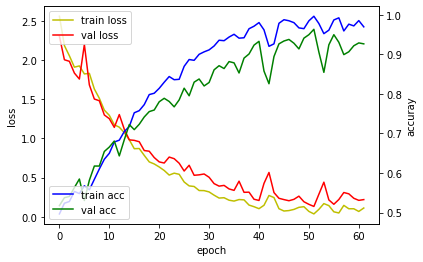

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [47]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
submission.to_csv('aug_cnn2_bilstm2.csv', index=False)

In [2]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32, callbacks = [es],  validation_data = (x_val, y_val))

NameError: name 'x' is not defined